# Spotify Data Analysis (Unified Data)

## 1. Introduction
In this notebook, we will:
1. Load two datasets extracted from our SQLite database: `Data/extracted_final.csv` and `Data/extracted_cleaned.csv`.
2. **Merge and Clean** them to create a unified dataset.
3. Perform **Advanced EDA** (Time trends, Top Artists, Content types).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Set visualization style
sns.set_theme(style="whitegrid")
%matplotlib inline

# Ensure Report directory exists for plots
if not os.path.exists('Report'):
    os.makedirs('Report')

## 2. Load & Merge Data

In [2]:
try:
    # UPDATED PATHS to Data/ folder
    df1 = pd.read_csv('Data/extracted_final.csv')
    df2 = pd.read_csv('Data/extracted_cleaned.csv')
    print(f"Dataset 1 shape: {df1.shape}")
    print(f"Dataset 2 shape: {df2.shape}")

    # Standardize columns before merging
    if 'track_duration_ms' in df1.columns and 'track_duration_min' not in df1.columns:
        df1['track_duration_min'] = df1['track_duration_ms'] / 60000
    
    if 'track_duration_min' in df2.columns and 'track_duration_ms' not in df2.columns:
        df2['track_duration_ms'] = df2['track_duration_min'] * 60000
    
    # Merge datasets
    df = pd.concat([df1, df2], ignore_index=True)
    print(f"Combined shape (before cleaning): {df.shape}")
    
except FileNotFoundError:
    print("Error: Extracted CSVs not found. Run etl_pipeline.py first.")

Dataset 1 shape: (8778, 15)
Dataset 2 shape: (8582, 15)
Combined shape (before cleaning): (17360, 16)


## 3. Data Cleaning

In [3]:
# 1. Drop duplicates
if 'track_number' in df.columns and 'track_name' in df.columns:
    initial_rows = len(df)
    # We can try dropping duplicates based on a subset if 'track_id' is missing or unreliable,
    # but assuming track_id is present in both:
    if 'track_id' in df.columns:
         df.drop_duplicates(subset=['track_id'], keep='first', inplace=True)
    else:
         df.drop_duplicates(inplace=True)
    print(f"Removed {initial_rows - len(df)} duplicate rows.")

# 2. Handle missing values
df.dropna(inplace=True)
print(f"Final clean dataset size: {len(df)} rows.")

Removed 8582 duplicate rows.
Final clean dataset size: 8772 rows.


## 4. Advanced Feature Engineering

In [4]:
# Convert Release Date to Year
df['release_year'] = pd.to_datetime(df['album_release_date'], errors='coerce').dt.year

# Filter data with valid years
df = df.dropna(subset=['release_year'])
df['release_year'] = df['release_year'].astype(int)
print("Year extracted successfully.")

Year extracted successfully.


## 5. Visualizations

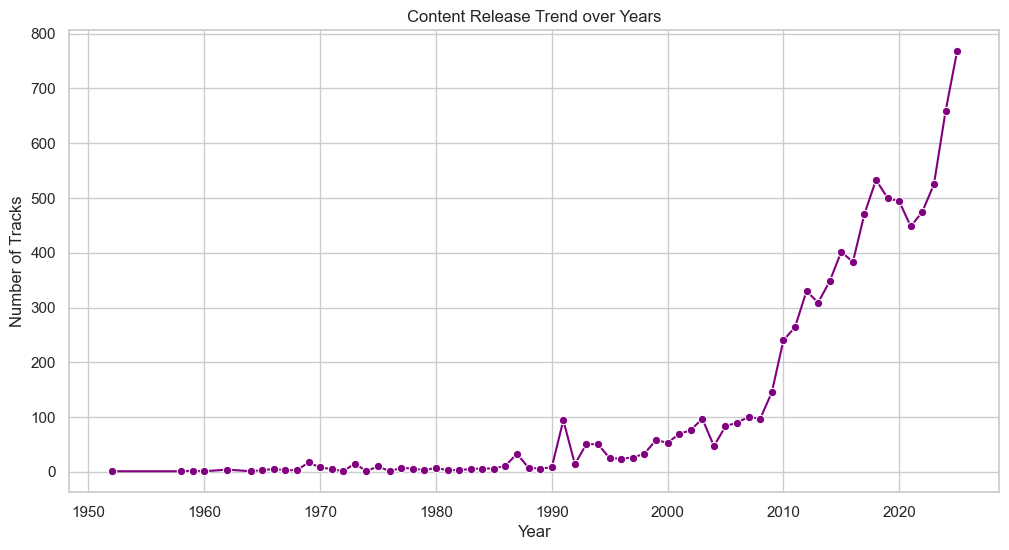

In [5]:
# 1. Time Trend: Number of Tracks per Year
plt.figure(figsize=(12, 6))
tracks_per_year = df['release_year'].value_counts().sort_index()
sns.lineplot(x=tracks_per_year.index, y=tracks_per_year.values, marker='o', color='purple')
plt.title('Content Release Trend over Years')
plt.xlabel('Year')
plt.ylabel('Number of Tracks')
plt.savefig('Report/plot_time_trend.png')
plt.show()

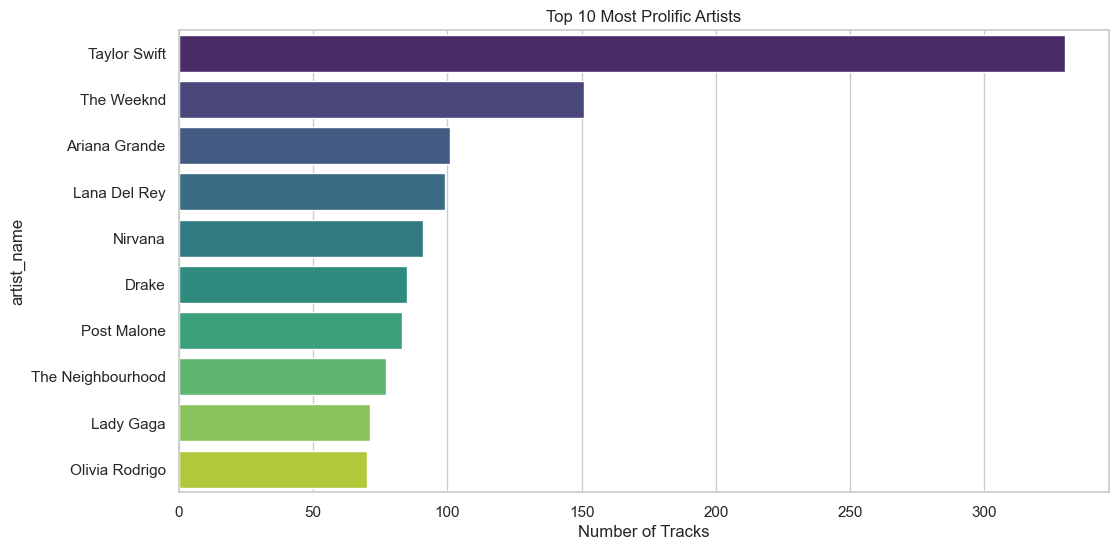

In [6]:
# 2. Top 10 Artists by Track Count
plt.figure(figsize=(12, 6))
top_artists = df['artist_name'].value_counts().head(10)
sns.barplot(y=top_artists.index, x=top_artists.values, palette='viridis', hue=top_artists.index, legend=False)
plt.title('Top 10 Most Prolific Artists')
plt.xlabel('Number of Tracks')
plt.savefig('Report/plot_top_artists.png')
plt.show()

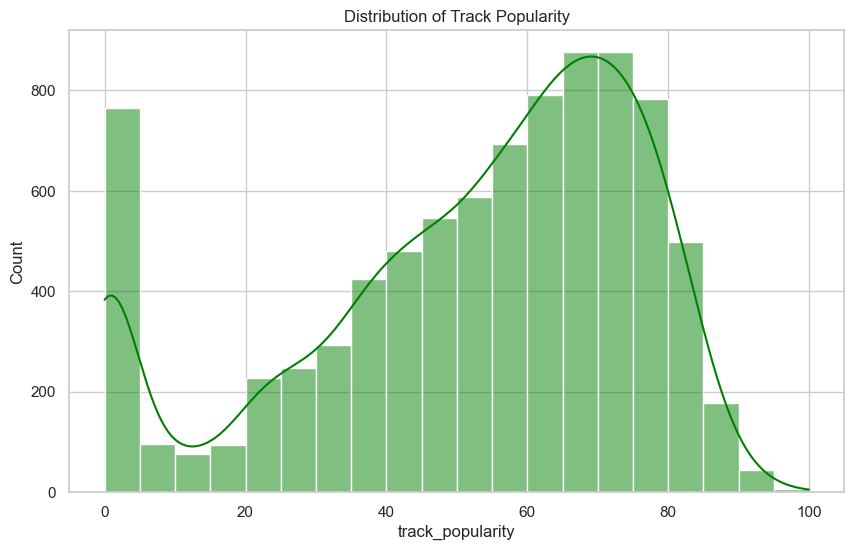

In [7]:
# 3. Popularity Distribution
plt.figure(figsize=(10, 6))
col_pop = 'track_popularity' if 'track_popularity' in df.columns else 'pypopularity'
if col_pop in df.columns:
    sns.histplot(df[col_pop], bins=20, kde=True, color='green')
    plt.title('Distribution of Track Popularity')
    plt.savefig('Report/plot_popularity.png')
    plt.show()
else:
    print("Popularity column not found.")

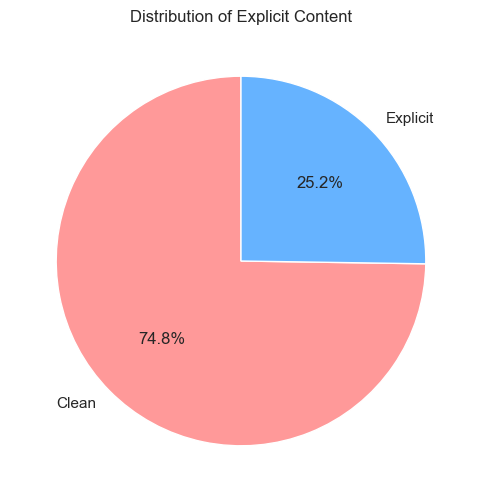

In [8]:
# 4. Explicit vs Clean Content
plt.figure(figsize=(6, 6))
if 'explicit' in df.columns:
    explicit_counts = df['explicit'].value_counts()
    labels = [str(l) for l in explicit_counts.index]
    final_labels = []
    for l in labels:
        if l in ['1', 'True', '1.0']:
            final_labels.append('Explicit')
        elif l in ['0', 'False', '0.0']:
            final_labels.append('Clean')
        else:
            final_labels.append(l)

    plt.pie(explicit_counts, labels=final_labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
    plt.title('Distribution of Explicit Content')
    plt.savefig('Report/plot_explicit.png')
    plt.show()
else:
    print("Explicit column not found.")